In [6]:
from __future__ import annotations

import struct
import subprocess
from pathlib import Path

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

FFT_EXEC = Path.cwd() / "build" / "release" / "processing_test.exe"

# Input constants
NUM_BYTES = 4         # Number of bytes per sample (currently f32)
FFT_SIZE = 2048        # Number of samples in FFT
SAMPLE_RATE = 44_100  # Audio sample rate, in Hz

DTYPE = ">f4"

# Calculated constants
FFT_OUT_SIZE = FFT_SIZE // 2
SAMPLE_TIME = 1 / SAMPLE_RATE
CHUNK_TIME = SAMPLE_TIME * FFT_SIZE


def plot_chunk(
    sample_idex: int,
    freqs: np.ndarray,
    raw_samples: np.ndarray,
    fft_samples: np.ndarray,
    # window: np.ndarray,
) -> None:
    fig = plt.figure(constrained_layout=True)
    gs = gridspec.GridSpec(3, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(np.arange(sample_idex, sample_idex + len(raw_samples), dtype=np.float32) * SAMPLE_TIME, raw_samples)
    ax1.set_title("Time domain signal")

    db_power = 10 * np.log10(fft_samples )
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(freqs, db_power)
    ax2.set_ylabel("Power (dB)")
    ax2.set_title("Implementation FFT")
    # ax2.set_xscale('log')
    # ax2.set_ylim((-20, 30))

    plt.show()


def process_chunk(raw_samples: np.ndarray, sample_index: int) -> None:
    print("Processing {0} samples: [{1}, ...]".format(len(raw_samples), ", ".join(map(str, raw_samples[:5]))))
    raw_samples.tofile("in.tmp")
    print("Subproc output:", subprocess.check_output([str(FFT_EXEC)]).decode())

    fft_samples = np.fromfile("out.tmp", dtype=DTYPE)
    print("FFT len: ", len(fft_samples))

    freqs = SAMPLE_RATE * np.arange((FFT_SIZE / 2)) / FFT_SIZE

    plot_chunk(sample_index, freqs, raw_samples, fft_samples)




# Generated

dtype: >f4
2048 [ 0.          1.6834811  -0.37735558 ... -1.6893222  -3.0726817
 -0.4278456 ]
Processing 2048 samples: [0.0, 1.6834811, -0.37735558, 2.4578733, 1.825911, ...]
Subproc output: 
FFT len:  1024


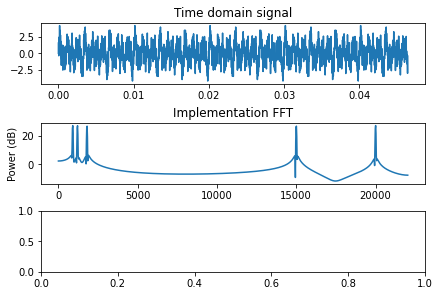

In [7]:
indexes = np.arange(SAMPLE_RATE * CHUNK_TIME)
samples = (
    np.sin(2 * np.pi * indexes * 900 / SAMPLE_RATE)
    + np.sin(2 * np.pi * indexes * 1200 / SAMPLE_RATE)
    + np.sin(2 * np.pi * indexes * 1800 / SAMPLE_RATE)
    + np.sin(2 * np.pi * indexes * 15000 / SAMPLE_RATE)
    + np.sin(2 * np.pi * indexes * 20000 / SAMPLE_RATE)
).astype(DTYPE)
print("dtype: {}".format(samples.dtype))
print(len(samples), samples)
process_chunk(samples, 0)

# From samples

Raw len:  8192
Processing 2048 samples: [8.835718e-08, 7.1891145e-07, -1.6947373e-06, -9.174931e-07, 1.9394986e-06, ...]
Subproc output: 
FFT len:  1024


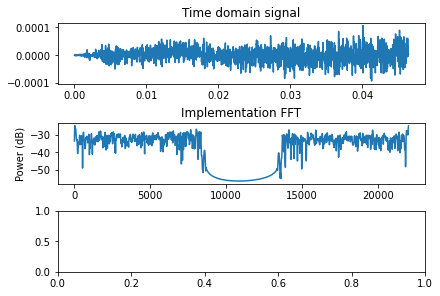

In [8]:
with open("raw.bin", "rb") as rs:
    sample_index = 0

    raw_bytes = rs.read(FFT_SIZE * NUM_BYTES)
    print("Raw len: ", len(raw_bytes))
    raw_samples = np.zeros(FFT_SIZE, dtype=DTYPE)
    for i in range(FFT_SIZE):
        raw_samples[i] = struct.unpack(">f", raw_bytes[i * NUM_BYTES:(i + 1) * NUM_BYTES])[0]

    process_chunk(raw_samples, sample_index)
    sample_index += 4